In [41]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt 
from utils import *
from kernel_sca_inducing_points import *
from kernels import *
import plotly.graph_objs as go
import plotly.express as px 

In [54]:

directory_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/So and Shadlen 2022/PSTHs'

files = [f for f in os.listdir(directory_path) if 'DotsOn_Leader' in f]

PSTHs = []
for file in files:
    try:
        mat_data = scipy.io.loadmat(f'{directory_path}/{file}')    
        PSTHs.append(np.vstack(mat_data['DotsOn'].squeeze()))
    except Exception as e:
        print(f"Error processing {file}: {e}")

PSTHs = np.stack(PSTHs)
ids = [ 0, 1, 2, 3, 4, -5, -4, -3, -2, -1]
print(PSTHs.shape)
PSTHs = PSTHs[:,ids,2:-5] #

Error processing DotsOn_Leader_1_22.mat: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 26 and the array at index 5 has size 1
(89, 12, 26)


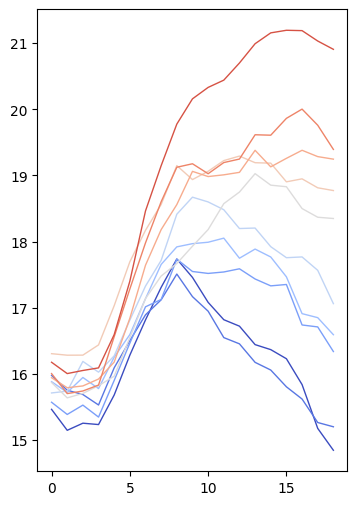

In [55]:
test = np.mean(PSTHs, axis=0)
K, T = test.shape

fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
cmap = plt.cm.coolwarm
for k in range(K):
    x = test[k, :]
    color = cmap(k / K)
    ax.plot(x, linestyle='-', linewidth=1, color=color) #marker='.'


In [56]:
X = PSTHs.swapaxes(0,1)
X, _ = pre_processing(X, soft_normalize='max', center=False, num_pcs=6) #pca=False

K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)  



In [57]:
d = 3
c = 40
kernel_function = K_X_Y_squared_exponential

wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

Iteration 0, S: 0.011077255010604858, S_ratio: 0.15756413340568542
Iteration 10, S: 0.03250236064195633, S_ratio: 0.3095472455024719
Iteration 20, S: 0.0719228982925415, S_ratio: 0.30112335085868835
Iteration 30, S: 0.2547284960746765, S_ratio: 0.5023975372314453
Iteration 40, S: 0.6582610011100769, S_ratio: 0.49854984879493713
Iteration 50, S: 0.8175725340843201, S_ratio: 0.4892730414867401
Iteration 60, S: 1.3597944974899292, S_ratio: 0.45597055554389954
Iteration 70, S: 1.664422631263733, S_ratio: 0.4557226002216339
Iteration 80, S: 1.663129210472107, S_ratio: 0.45846906304359436
Iteration 90, S: 1.9021589756011963, S_ratio: 0.44442328810691833
Iteration 100, S: 2.2096402645111084, S_ratio: 0.44327035546302795
Iteration 110, S: 2.2440171241760254, S_ratio: 0.43651214241981506
Iteration 120, S: 2.1827614307403564, S_ratio: 0.4274822771549225
Iteration 130, S: 2.1477410793304443, S_ratio: 0.4319741129875183
Iteration 140, S: 2.557201385498047, S_ratio: 0.4346179962158203
Iteration 150

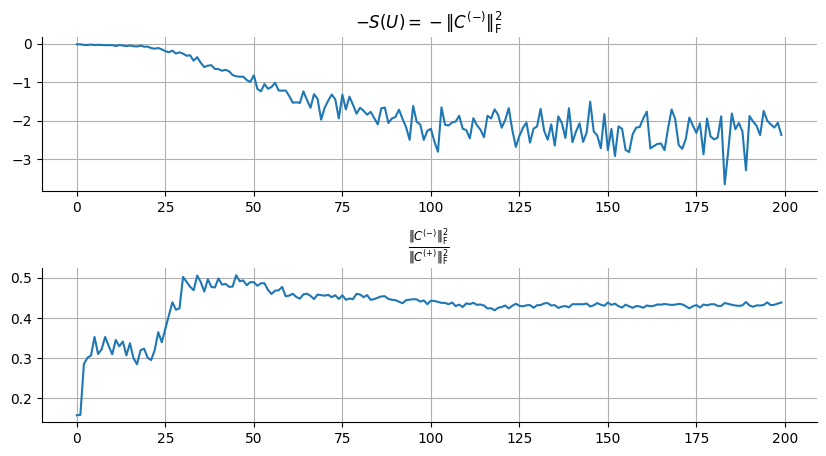

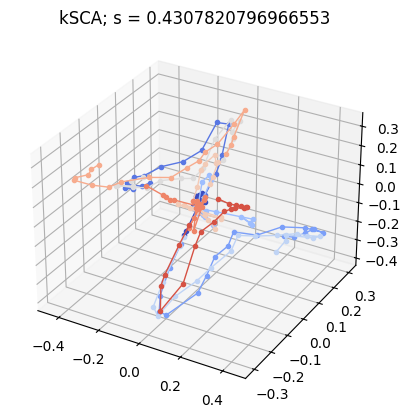

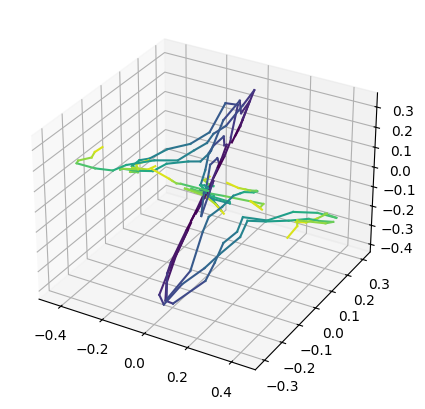

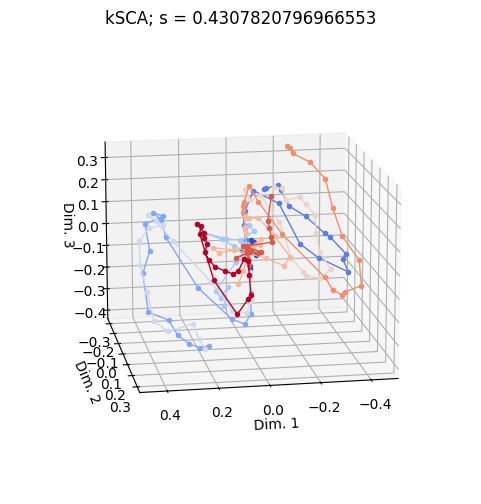

<Figure size 640x480 with 0 Axes>

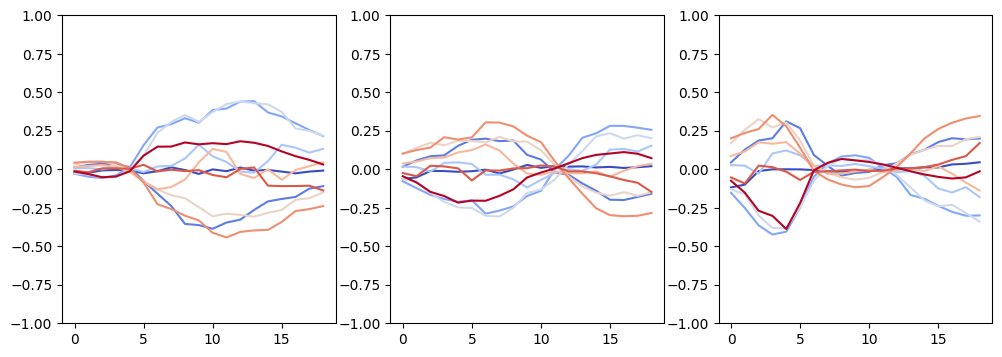

In [58]:
get_loss_fig(ls_loss, ls_S_ratio)

_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, H_K_A_u, alpha= get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.coolwarm
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :] 
    color = cmap(k / K)
    ax.plot(x, y, z, linestyle='-', marker='.', linewidth=1, color=color)
    #ax.plot(x, y, linestyle='-', marker='.', linewidth=1, color=color)

plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

plot_3D(Y[:,:,:])

analyse_projs(Y)

In [45]:
def analyse_projs(Y, ymin = -1, ymax=1):
    K, _, _ = Y.shape
 

    plot_3D_K_coded(Y, rotate=True, azimuth=80, elevation=15)

    plt.figure()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(Y.shape[0]):
        color = cmap(k / (K - 1)) 
        axs[0].plot(Y[k, 0, :], color=color)
        axs[1].plot(Y[k, 1, :], color=color)
        axs[2].plot(Y[k, 2, :], color=color)

    for ax in axs:
        ax.set_ylim(ymin, ymax)

Iteration 0, S: 0.2781980335712433, S_ratio: 0.2109750211238861
Iteration 10, S: 0.4333324134349823, S_ratio: 0.20061174035072327
Iteration 20, S: 1.1837759017944336, S_ratio: 0.19178159534931183
Iteration 30, S: 2.655824661254883, S_ratio: 0.18617920577526093
Iteration 40, S: 3.14597487449646, S_ratio: 0.16849540174007416
Iteration 50, S: 5.312340259552002, S_ratio: 0.1730906367301941
Iteration 60, S: 7.3360419273376465, S_ratio: 0.1615941971540451
Iteration 70, S: 10.876643180847168, S_ratio: 0.15889114141464233
Iteration 80, S: 11.537909507751465, S_ratio: 0.16363035142421722
Iteration 90, S: 14.185293197631836, S_ratio: 0.16220444440841675
Iteration 100, S: 19.751728057861328, S_ratio: 0.17479941248893738
Iteration 110, S: 20.658775329589844, S_ratio: 0.18784409761428833
Iteration 120, S: 27.394786834716797, S_ratio: 0.19685927033424377
Iteration 130, S: 25.520673751831055, S_ratio: 0.2035893052816391
Iteration 140, S: 31.40410614013672, S_ratio: 0.19923150539398193
Iteration 150, 

Text(0.5, 0.92, 'SCA; s = 0.20388610661029816')

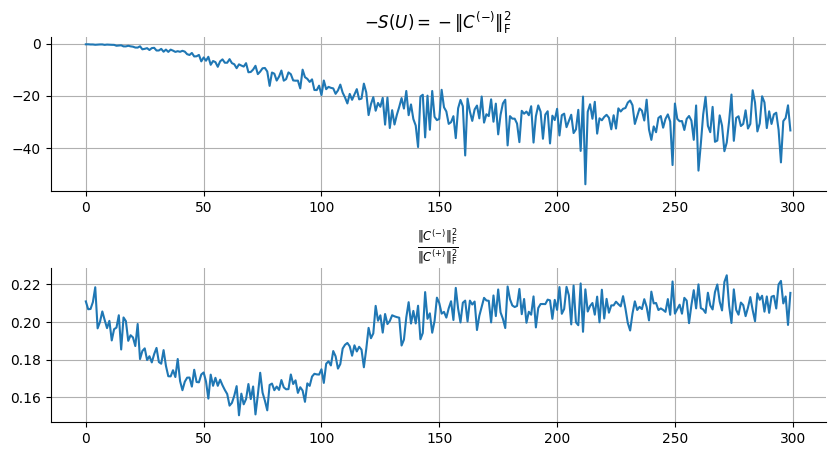

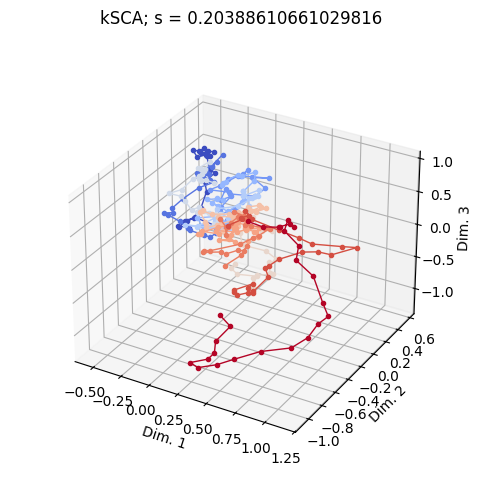

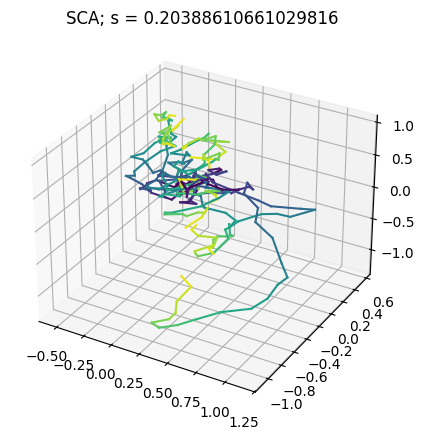

In [39]:
from linear_sca import *
d=3
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X), d=d, learning_rate=0.01, iterations=300) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X))

    
plot_3D_K_coded(Y)

plot_3D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

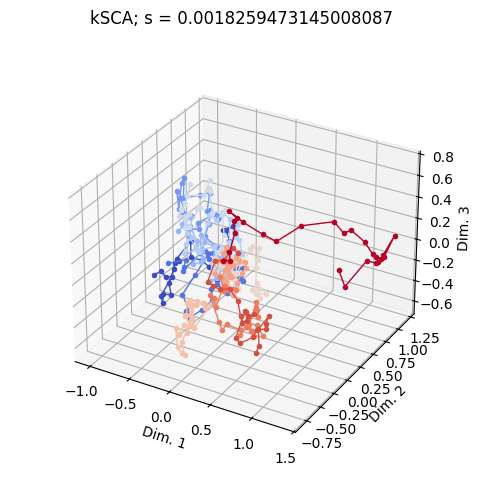

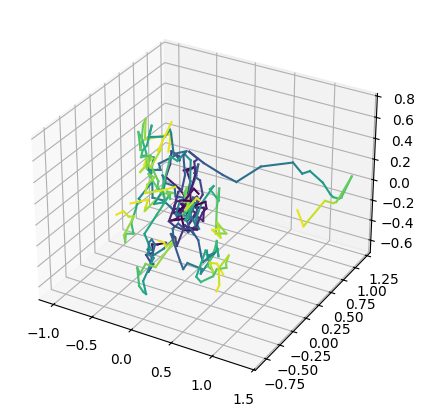

In [38]:
Y_pca, PCs = get_pca(center(X), num_pcs=d)

    
plot_3D_K_coded(jnp.array(Y_pca))

plot_3D(Y_pca)

ENDS HERE 

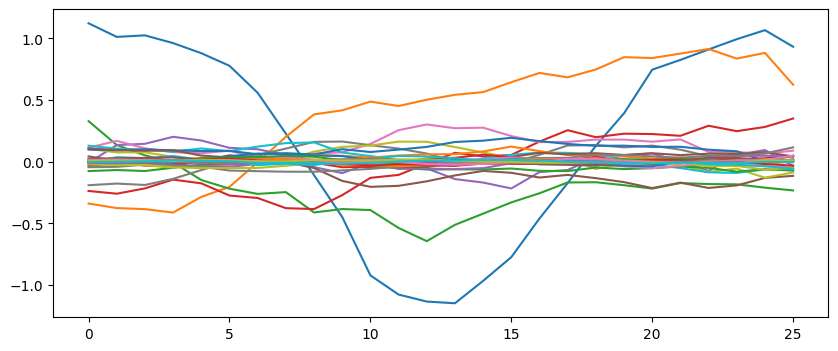

In [40]:
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.plot( X[-1,i,:] )

In [34]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()